In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style 
style.use('ggplot')
import random
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

import optuna
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


In [2]:
PATH = "/kaggle/input/tabular-playground-series-apr-2022/"
trainFeatures = pd.read_csv(PATH+"train.csv")
testData = pd.read_csv(PATH+"test.csv")
trainLabels = pd.read_csv(PATH+"train_labels.csv")

In [3]:
##Merging labels with sensor data
trainData = trainFeatures.merge(trainLabels, on = "sequence")

def exploreDataset(df):
    df_copy = df.copy()
    print("The {} contains {} rows with {} N/A values".format("df", df.shape[0], df_copy.isna().sum()))
    

exploreDataset(trainData)
sensorData = [col for col in trainData.columns if col.startswith("sensor")]

The df contains 1558080 rows with sequence     0
subject      0
step         0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
state        0
dtype: int64 N/A values


**Correlation Plot for all the sensors in given dataset**

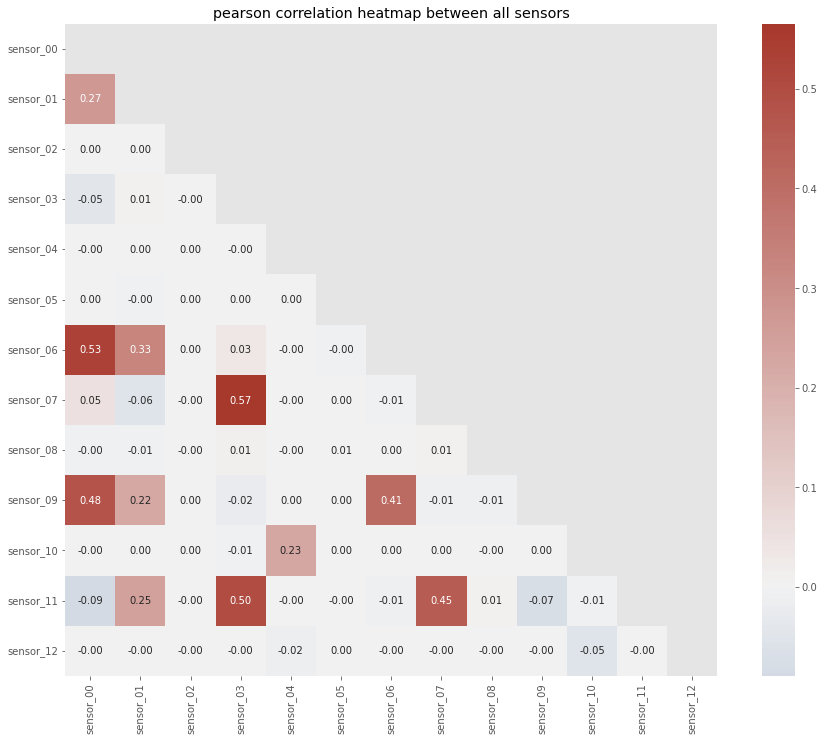

In [4]:
def drawCorrelationMatrix(df, method = 'pearson'):
    
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)
    matrix = df.corr(method = method)
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    plt.figure(figsize=(16,12))
    plt.title("{} correlation heatmap between all sensors".format(method))
    fig = sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    
drawCorrelationMatrix(trainData[sensorData])

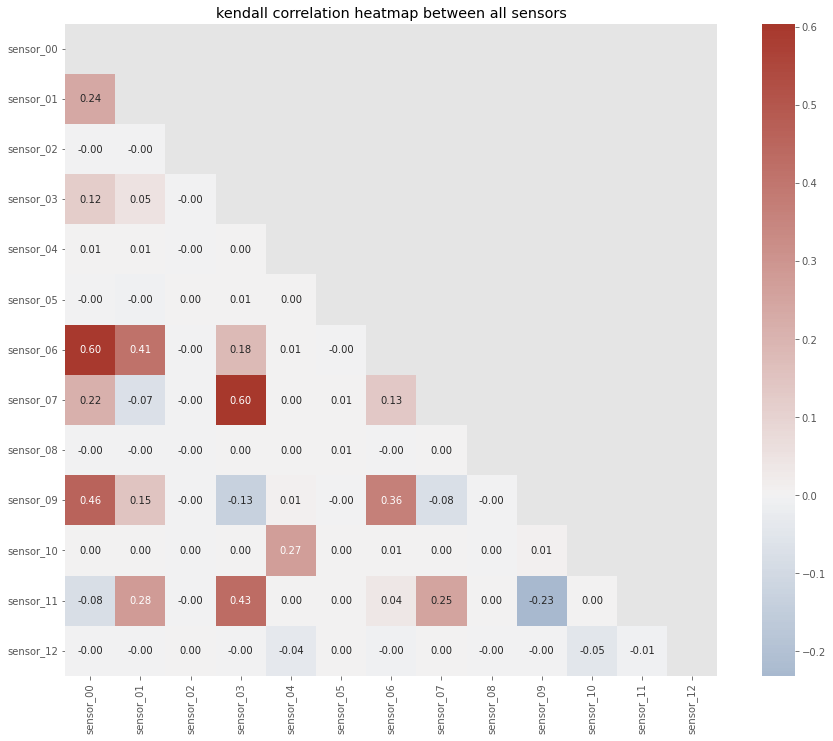

In [5]:
drawCorrelationMatrix(trainData[sensorData],method = 'kendall')

From the heat map we came to know that there is no correlation between sensor data except few. So all these sensors picks up value which are not correlated to one another

In [6]:
def getRedundantPairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def getTopAbsCorrelations(df, n=5, method = 'pearson'):
    au_corr = df.corr(method = method).abs().unstack()
    labels_to_drop = getRedundantPairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    print("Top {} Correlated features in given dataset".format(n))
    return au_corr[0:n]

getTopAbsCorrelations(traindata[sensorData], 4)

NameError: name 'traindata' is not defined

**Plotting Histogram for 1st 60 Sequences**

In [ ]:
SENSOR_COUNT = 13
random_sequence = 10000
df = trainData[trainData['sequence']==10000]
plt.figure(figsize=(16,24))
for i in range(SENSOR_COUNT):
    plt.subplot(6,3,i+1,aspect='auto')
    sensor = 'sensor_'+str(i).zfill(2)
    sns.kdeplot(data=df,x=sensor)
plt.suptitle(f'Kde Plots of Sensors:{random_sequence}')
plt.show()

In [ ]:
SEED = 10
random.seed(SEED) # Set the seed for reproducibilty
random_sequence = random.randint(trainData['sequence'].min(), traindata['sequence'].max())

df = trainData[trainData['sequence']==random_sequence]

SENSOR_COUNT = 13 # Thirteen sensors used for measurements
subject_number = df['subject'].unique()[0] # Subject numbers seems unique for particlar sequence

plt.figure(figsize=(16,12))
for i in range(SENSOR_COUNT):
    plt.subplot(6,3,i+1)
    sensor = 'sensor_'+str(i).zfill(2)
    sns.lineplot(data=df,x='step',y=sensor)
plt.suptitle(f'Time Series Chart of Sensors for Sequence:{random_sequence} and Subject: {subject_number}')
plt.show()

As the number of sensors are 13, We can use Principal component analysis to reduce the dimensity of data by taking pricipal components retaining 95% variance of data

In [ ]:
trainFeatures.drop(['sequence', 'subject', 'step'], axis=1, inplace=True)
testData.drop(['sequence', 'subject', 'step'], axis=1, inplace=True)
trainLabels.drop('sequence', axis=1, inplace=True)

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_features = scaler.fit_transform(trainFeatures)
# test_data = scaler.transform(testData)

In [ ]:
train_features = trainFeatures.values.reshape(int(len(trainFeatures)/60), 60, 13)
test_df = testData.values.reshape(int(len(testData)/60), 60, 13)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_features, trainLabels)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Input
from keras.layers import Dropout,MaxPooling1D, GlobalMaxPooling1D

model = Sequential()
model.add(Input(shape=(60,13)))
model.add(LSTM(128, return_sequences=True))
model.add(MaxPooling1D())
model.add(LSTM(512, return_sequences=True))
model.add(MaxPooling1D())
model.add(LSTM(256, return_sequences=True))
model.add(MaxPooling1D())
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
history = model.fit(X_train, y_train, batch_size=500, epochs=10, validation_data=(X_val, y_val))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
submission = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv', index_col=0)
submission['state'] = model.predict(test_df)
submission

In [ ]:
submission.to_csv('submission.csv', index=True)